# Tutorial: Dispatcher

This notebook demonstrates how to use dispatcher.

In [1]:
from flumodelingsuite.config_loader import load_basemodel_config_from_file, load_sampling_config_from_file, load_calibration_config_from_file, load_output_config_from_file
from flumodelingsuite.schema.general import validate_modelset_consistency

In [2]:
from flumodelingsuite.dispatcher.builder import dispatch_builder
from flumodelingsuite.dispatcher.runner import dispatch_runner
from flumodelingsuite.dispatcher.output import dispatch_output_generator

In [3]:
from epydemix.visualization import plot_quantiles
from matplotlib import pyplot as plt
from io import StringIO
import pandas as pd
import numpy as np
import gzip

In [4]:
# import logging
# import sys

# root = logging.getLogger()
# if root.handlers:
#     root.handlers.clear()

# logging.basicConfig(
#     level=logging.INFO,
#     stream=sys.stdout,
#     format="%(asctime)s %(name)s %(levelname)s: %(message)s",
# )

***
## Loading configs

In [5]:
basemodel_config_sampling = load_basemodel_config_from_file("data/flu_round05_basemodel_sampling.yml")
basemodel_config_calibration = load_basemodel_config_from_file("data/flu_round05_basemodel_calibration.yml")
basemodel_config_standalone = load_basemodel_config_from_file("data/basic_basemodel_standalone.yml")

In [6]:
sampling_config = load_sampling_config_from_file("data/flu_round05_modelset_sampling.yml")

In [7]:
calibration_config = load_calibration_config_from_file("data/flu_round05_modelset_calibration.yml")

In [8]:
output_config = load_output_config_from_file("data/basic_output.yaml")

In [9]:
# Override calibration settings temporarily
calibration_config.modelset.calibration.strategy.options['num_generations'] = 7

***
## Validate config consistency

In [10]:
validate_modelset_consistency(basemodel_config_sampling, sampling_config)

In [11]:
validate_modelset_consistency(basemodel_config_calibration, calibration_config)

***
## Dispatcher - Builder

In [12]:
builder_output_sampling = dispatch_builder(basemodel_config=basemodel_config_sampling, sampling_config=sampling_config)

In [13]:
builder_output_calibration = dispatch_builder(basemodel_config=basemodel_config_calibration, calibration_config=calibration_config)

In [14]:
builder_output_standalone = dispatch_builder(basemodel_config=basemodel_config_standalone)

***
## Dispatcher - Runner

In [15]:
runner_output_sampling = dispatch_runner(builder_output_sampling[0])

RuntimeError: Error during simulation: Simulation failed: pvals < 0, pvals > 1 or pvals contains NaNs

In [16]:
runner_output_calibration = dispatch_runner(builder_output_calibration[0])

Starting ABC-SMC with 20 particles and 7 generations

Generation 1/7 (epsilon: inf)
	Accepted 20/20 (acceptance rate: 100.00%)
	Elapsed time: 00:00:03

Generation 2/7 (epsilon: 625.746172)
	Accepted 20/47 (acceptance rate: 42.55%)
	Elapsed time: 00:00:08

Generation 3/7 (epsilon: 575.097904)
	Accepted 20/68 (acceptance rate: 29.41%)
	Elapsed time: 00:00:12

Generation 4/7 (epsilon: 464.149148)
	Accepted 20/216 (acceptance rate: 9.26%)
	Elapsed time: 00:00:40

Generation 5/7 (epsilon: 344.839311)
	Accepted 20/130 (acceptance rate: 15.38%)
	Elapsed time: 00:00:23

Generation 6/7 (epsilon: 245.774395)
	Accepted 20/266 (acceptance rate: 7.52%)
	Elapsed time: 00:00:47

Generation 7/7 (epsilon: 186.639480)
	Accepted 20/725 (acceptance rate: 2.76%)
	Elapsed time: 00:02:08


In [17]:
runner_output_standalone = dispatch_runner(builder_output_standalone)

***
## Dispatcher - Output Generator

In [18]:
# Generate outputs for calibration projection results
calibration_output_files = dispatch_output_generator(calibrations=[runner_output_calibration], output_config=output_config)

In [19]:
# # Save the generated outputs to disk
# import os
# output_dir = "output"
# os.makedirs(output_dir, exist_ok=True)

# print(f"Generated {len(output_files)} output files:")
# for filename, gzipped_data in output_files.items():
#     filepath = os.path.join(output_dir, filename)
#     with open(filepath, "wb") as f:
#         f.write(gzipped_data)
#     print(f"  - Saved: {filepath} ({len(gzipped_data)} bytes)")

## Plotting

In [20]:
calibration_quantiles = runner_output_calibration.results.get_calibration_quantiles()

In [21]:
projection_quantiles = runner_output_calibration.results.get_projection_quantiles()

In [22]:
# Sum up transitions
projection_quantiles['data'] = np.sum(projection_quantiles[['Home_sev_to_Hosp_total', 'Home_sev_vax_to_Hosp_vax_total']], axis=1)

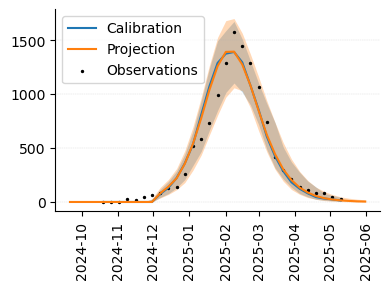

In [23]:
fig, ax = plt.subplots(1,1, figsize=(4,3))

# ax.scatter(x, y, marker='o', lw=0)
plot_quantiles(
    calibration_quantiles,
    ax=ax,
    labels="Calibration",
    columns=["data"],
    colors="C0",
)

plot_quantiles(
    projection_quantiles,
    ax=ax,
    labels="Projection",
    columns=["data"],
    colors="C1",
)

ax.scatter(
    calibration_quantiles['date'].unique(),
    runner_output_calibration.results.observed_data['data'],
    color='black',
    label='Observations',
    s=2
)

ax.set_title("", loc='left')

ax.set_xlabel("")
ax.set_ylabel("")

ax.tick_params(axis='x', labelrotation=90)

ax.legend(loc='upper left', frameon=True)

fig.tight_layout()
plt.show()

## FluSight Format Output

In [24]:
pd.read_csv(StringIO(gzip.decompress(calibration_output_files["output_hub_formatted.csv.gz"]).decode()))

,location,reference_date,horizon,target_end_date,target,output_type,output_type_id,value
0,25,2025-04-05,-1,2025-03-29,wk inc flu hosp,quantile,0.01,102.0
1,25,2025-04-05,0,2025-04-05,wk inc flu hosp,quantile,0.01,63.0
2,25,2025-04-05,1,2025-04-12,wk inc flu hosp,quantile,0.01,35.0
3,25,2025-04-05,2,2025-04-19,wk inc flu hosp,quantile,0.01,20.0
4,25,2025-04-05,3,2025-04-26,wk inc flu hosp,quantile,0.01,10.0
...,...,...,...,...,...,...,...,...
130,25,2025-04-05,3,2025-04-26,wk flu hosp rate change,pmf,large_decrease,1.0
131,25,2025-04-05,3,2025-04-26,wk flu hosp rate change,pmf,stable,0.0
132,25,2025-04-05,3,2025-04-26,wk flu hosp rate change,pmf,increase,0.0
133,25,2025-04-05,3,2025-04-26,wk flu hosp rate change,pmf,decrease,0.0
